# 🌊 HydroPipeline: Resilient Hydrological Data Ingestion (ANA/SNIRH)

**Author:** Ana Paula Leão
**Tech Stack:** Python, Pandas, HydroBr, OOP (Object-Oriented Programming), Retry Pattern.

---

## 📋 Project Overview
This project implements an **End-to-End Data Engineering (ETL) pipeline** for the automated and resilient extraction of historical time-series data from the **Brazilian National Water Agency (ANA)**.

The focus is monitoring the **Miranda River Basin (Pantanal Biome)**, a critical region subject to extreme drought and flood events. The solution was architected to overcome public API instabilities, ensuring data integrity for downstream predictive modeling (LSTM/Deep Learning).

## ⚙️ Architecture & Technical Decisions
To elevate the solution beyond basic scripting, the following patterns were adopted:
* **Object-Oriented Programming (OOP):** Encapsulation of Extraction and Loading logic for modularity.
* **Resilience (Retry Pattern):** Implementation of custom decorators to handle API intermittency automatically.
* **Bronze Layer (Raw):** Ingestion of raw data with minimal transformation, preserving the source of truth.
* **Idempotency:** The pipeline can be re-run multiple times without corrupting the dataset.

In [43]:
# --- 0. ENVIRONMENT SETUP ---
# Install libraries (quiet mode)
!pip install -q hydrobr matplotlib pandas

import hydrobr
import pandas as pd
import logging
import time
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from typing import List, Optional
from functools import wraps
from google.colab import drive # <--- IMPORTANTE

# 1. Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
warnings.filterwarnings('ignore')

# 2. Mount Google Drive (CRITICAL for Manual Fallback & Data Persistence)
# Isso permite que o código leia 'manual_upload' e salve em 'raw'
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [44]:
# --- 1. CONFIGURATION ---
@dataclass(frozen=True)
class PipelineConfig:
    """
    Immutable Configuration for the ETL Pipeline.
    """
    flow_stations: List[str]
    rain_stations: List[str]
    # Caminho base apontando para o seu Drive
    raw_path: Path = Path("/content/drive/MyDrive/datalake_simulated/raw")

    start_date: str = '1994-02-01'
    end_date: str = '2024-01-31'
    max_retries: int = 3
    retry_delay_seconds: int = 2

In [45]:

# --- 2. RESILIENCE DECORATOR ---
def retry_with_backoff(max_attempts: int, delay: int):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for attempt in range(1, max_attempts + 1):
                try:
                    return func(*args, **kwargs)
                except Exception as e:
                    logging.warning(f"⚠️ Attempt {attempt}/{max_attempts} failed: {e}")
                    if attempt == max_attempts:
                        logging.error("❌ All attempts failed.")
                        raise
                    time.sleep(delay)
        return wrapper
    return decorator

In [47]:
# --- 3. EXTRACTION LAYER (HYBRID: API + MANUAL FALLBACK) ---
class ANAExtractor:
    """
    Hybrid Extractor with Data Lineage.
    Strategy:
    1. Attempt to fetch fresh data from ANA API (HydroBr).
    2. If API fails or returns outdated data (pre-2023), switch to Manual Backup.
    3. Tag the dataset with 'data_origin' for auditability.
    """
    def __init__(self, config: PipelineConfig):
        self.config = config
        self._setup_environment()

    def _setup_environment(self):
        """Ensures raw folders exist."""
        (self.config.raw_path / "flow").mkdir(parents=True, exist_ok=True)
        (self.config.raw_path / "rainfall").mkdir(parents=True, exist_ok=True)

    def _load_manual_fallback(self, filename: str) -> pd.DataFrame:
        """
        Loads the manually downloaded CSV from the 'manual_upload' folder.
        Acts as a contingency plan for API instability.
        """
        # Caminho inteligente: sobe um nível (..) e procura 'manual_upload'
        manual_path = self.config.raw_path.parent / "manual_upload" / filename

        if manual_path.exists():
            logging.warning(f"📂 Fallback Triggered: Loading backup file from {manual_path}")
            # Importante: Ajuste 'sep' ou 'decimal' se seu Excel estiver diferente
            df = pd.read_csv(manual_path, index_col=0, parse_dates=True)

            # [LINEAGE] Carimba a origem do dado
            df['data_origin'] = 'MANUAL_UPLOAD'
            return df
        else:
            logging.error(f"❌ Critical Failure: API failed AND Manual file not found at {manual_path}")
            return None

    @retry_with_backoff(max_attempts=3, delay=2)
    def get_data(self, data_type: str) -> pd.DataFrame:
        """
        Orchestrates the extraction process with Lineage tracking.
        """
        logging.info(f"📡 Attempting API download for {data_type}...")

        try:
            # 1. Tenta baixar da API Oficial
            if data_type == "FLOW":
                result = hydrobr.get_data.ANA.flow_data(self.config.flow_stations)
            else:
                result = hydrobr.get_data.ANA.prec_data(self.config.rain_stations)

            # 2. Valida se o dado veio vazio ou muito antigo (opcional)
            if result is None or result.empty:
                raise ValueError("API returned Empty Data")

            # [LINEAGE] Carimba a origem do dado
            result['data_origin'] = 'API_ANA'

            logging.info(f"✅ Success: API retrieved {len(result)} records.")
            return result

        except Exception as e:
            # 3. Ativa o Plano B (Fallback)
            logging.warning(f"⚠️ API Connection Issue: {e}. Switching to Manual Fallback...")

            # Define o nome do arquivo manual esperado
            filename = "flow_data_manual.csv" if data_type == "FLOW" else "rainfall_data_manual.csv"

            return self._load_manual_fallback(filename)

    def run_flow_extraction(self) -> Optional[pd.DataFrame]:
        return self.get_data("FLOW")

    def run_rain_extraction(self) -> Optional[pd.DataFrame]:
        return self.get_data("RAINFALL")

In [48]:
# --- 4. LOADING LAYER ---
class DataLoader:
    """
    Handles data persistence (Bronze Layer).
    Decouples I/O logic from Business logic.
    """
    def __init__(self, config: PipelineConfig):
        self.config = config

    def _filter_by_date(self, df: pd.DataFrame) -> pd.DataFrame:
        """Applies business rules: Filters data based on Thesis timeframe."""
        if df is None or df.empty: return df
        logging.info(f"✂️ Filtering data between {self.config.start_date} and {self.config.end_date}...")
        return df.loc[self.config.start_date : self.config.end_date]

    def save_data(self, df: pd.DataFrame, folder: str, filename: str):
        if df is None or df.empty:
            logging.warning(f"⏩ No data to save for {filename}.")
            return

        # 1. Transformation (Filter)
        df_filtered = self._filter_by_date(df)

        # 2. Local Save (Bronze Layer Simulation)
        full_path = self.config.raw_path / folder / filename
        df_filtered.to_csv(full_path)
        logging.info(f"💾 [BRONZE LAYER] File saved to disk: {full_path}")

## 🚀 Pipeline Execution & Orchestration
The block below initializes the configuration with the specific stations for the **Miranda River** (MS, Brazil) and triggers the extraction processes.

In [49]:
# --- 5. ORCHESTRATION ---

# Configuration updated with Real Stations from the Master's Thesis
config = PipelineConfig(
    # Miranda River Flow Stations
    flow_stations=['66926000', '66941000', '66945000'],

    # Rainfall Stations (Pluviometric)
    rain_stations=[
        '1954002', '2054005', '2054009', '2054019',
        '2055002'
    ],
    # Path inside Colab/Drive
    raw_path=Path("./datalake_simulated/raw")
)

extractor = ANAExtractor(config)
loader = DataLoader(config)

print("\n--- 🚀 STARTING HYDROLOGICAL DATA PIPELINE ---")

# Execute Flow Pipeline
df_flow = extractor.run_flow_extraction()
loader.save_data(df_flow, "flow", "bronze_flow_data.csv")

# Execute Rainfall Pipeline
df_rain = extractor.run_rain_extraction()
loader.save_data(df_rain, "rainfall", "bronze_rainfall_data.csv")


--- 🚀 STARTING HYDROLOGICAL DATA PIPELINE ---


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


## 📊 Visual Validation & Hydrological Consistency

Following raw data ingestion, a visual inspection of the time series is performed. This step is critical within the Data Engineering pipeline to ensure:

1.  **Data Integrity:** Confirming that the raw CSV files are populated and not corrupted.
2.  **Consistency:** Verifying if river discharge patterns align with the expected hydrological seasonality of the **Miranda River Basin**.
3.  **Completeness:** Visually identifying significant data gaps that will require imputation or handling during the **Silver Layer** processing.

The plot below displays the daily discharge ($m^3/s$) for the monitored stations across the entire available historical timeframe.


📊 Generating Data Quality Report (Visual Inspection)...


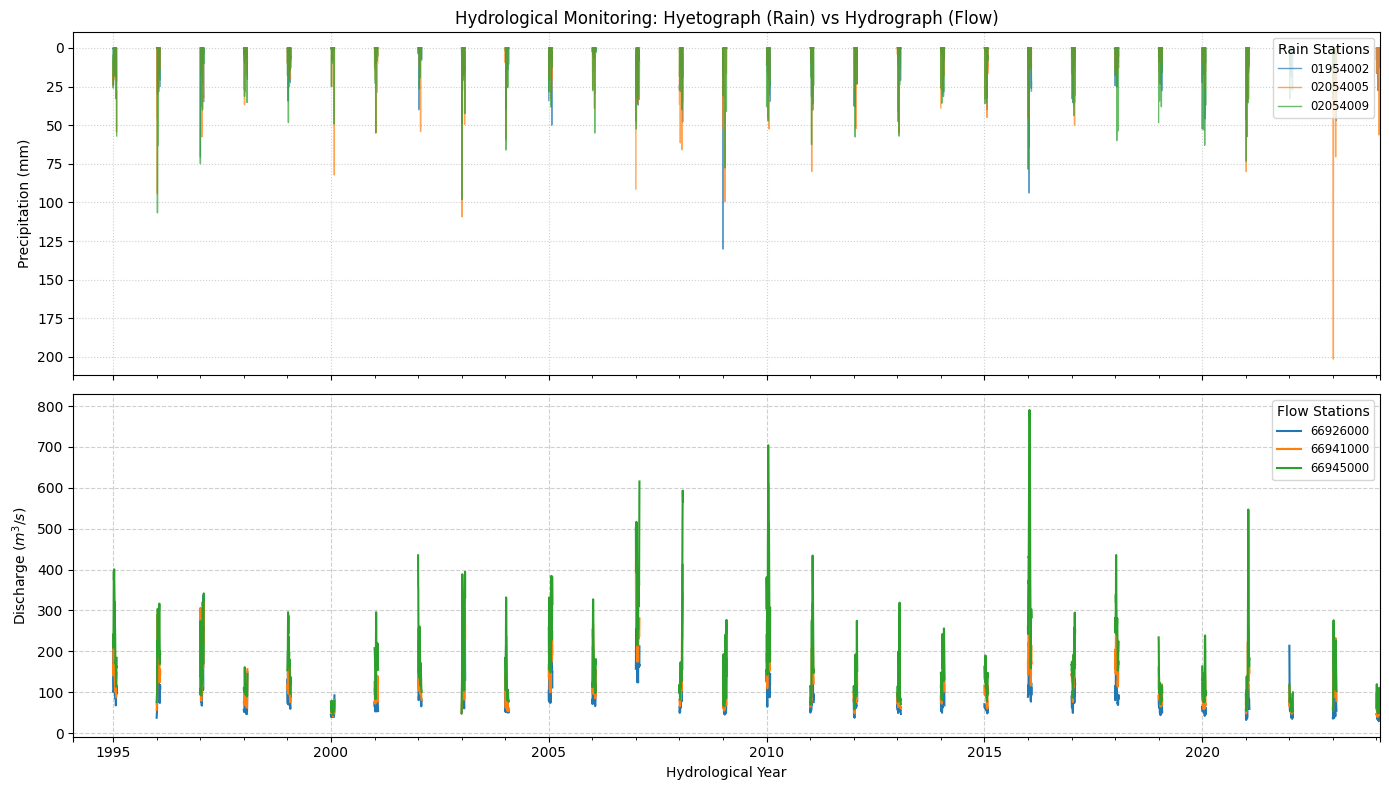

✅ Process completed successfully.


In [50]:
# --- 6. DATA QUALITY & VISUALIZATION ---
print("\n📊 Generating Data Quality Report (Visual Inspection)...")

if df_flow is not None or df_rain is not None:
    fig, (ax_rain, ax_flow) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Plot Rainfall (Inverted Y-axis is standard in Hydrology)
    if df_rain is not None:
        # Plotting first 3 stations to avoid clutter
        df_rain.iloc[:, :3].loc[config.start_date:config.end_date].plot(ax=ax_rain, lw=1, alpha=0.7)
        ax_rain.invert_yaxis()
        ax_rain.set_ylabel("Precipitation (mm)")
        ax_rain.set_title("Hydrological Monitoring: Hyetograph (Rain) vs Hydrograph (Flow)")
        ax_rain.legend(loc='upper right', fontsize='small', title="Rain Stations")
        ax_rain.grid(True, linestyle=':', alpha=0.6)

    # Plot Flow
    if df_flow is not None:
        df_flow.loc[config.start_date:config.end_date].plot(ax=ax_flow, lw=1.5)
        ax_flow.set_ylabel("Discharge ($m^3/s$)")
        ax_flow.set_xlabel("Hydrological Year")
        ax_flow.legend(loc='upper right', fontsize='small', title="Flow Stations")
        ax_flow.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()
    print("✅ Process completed successfully.")
else:
    print("⚠️ No data retrieved for visualization.")